In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import sklearn
import cv2
import time
import datetime

In [2]:
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Paths
images_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms"
labels_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/labels"

def center_crop_and_resize(image_path, target_size=(224, 224)):
    """
    Crops the center square of an image and resizes it to the target size.

    Args:
        image_path (str): Path to the input image.
        target_size (tuple): Target size for resizing (width, height).

    Returns:
        PIL.Image.Image: The cropped and resized image.
    """

    image = Image.open(image_path)
    width, height = image.size

    # Calculate the cropping box for a center square
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim

    # Crop the center square
    image = image.crop((left, top, right, bottom))

    # Resize to the target size
    image = image.resize(target_size, Image.Resampling.LANCZOS)

    return image

# Load dataset
def load_dataset(images_dir, labels_dir):
    images = []
    labels = []
    for image_file in os.listdir(images_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, image_file.replace(".jpg", ".json"))

            # Load and preprocess image
            image = center_crop_and_resize(image_path, target_size=(224, 224))  # Resize for ResNet50
            images.append(np.array(image) / 255.0)  # Normalize to [0, 1]

            # Load label
            with open(label_path, 'r') as f:
                label = json.load(f)
                labels.append([label["red_count"], label["green_count"], label["blue_count"]])

    return np.array(images), np.array(labels)

images, labels = load_dataset(images_dir, labels_dir)
# augmented_images_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/images_augmented"
# augmented_labels_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/labels_augmented"
# augmented_images, augmented_labels = load_dataset(augmented_images_dir, augmented_labels_dir)


In [4]:
images.shape

(2498, 224, 224, 3)

In [6]:
# Shuffle the augmented data
augmented_images, augmented_labels = sklearn.utils.shuffle(augmented_images, augmented_labels, random_state=42)

# Fraction of augmented data to include
fraction_to_include = 0.5

# Randomly sample 50% of the augmented dataset
num_augmented_samples = int(len(augmented_images) * fraction_to_include)
selected_indices = np.random.choice(len(augmented_images), num_augmented_samples, replace=False)

# Select the sampled augmented data and labels
selected_augmented_images = augmented_images[selected_indices]
selected_augmented_labels = augmented_labels[selected_indices]

# Combine original and sampled augmented data
merged_images = np.concatenate([images, selected_augmented_images], axis=0)
merged_labels = np.concatenate([labels, selected_augmented_labels], axis=0)

# Shuffle the merged dataset
merged_images, merged_labels = sklearn.utils.shuffle(merged_images, merged_labels, random_state=42)

# Print the sizes of the merged datasets
print(f"Total images: {merged_images.shape[0]}")
print(f"Total labels: {merged_labels.shape[0]}")

: 

: 

In [5]:
# Shuffle the training data
images, labels = sklearn.utils.shuffle(images, labels, random_state=42)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


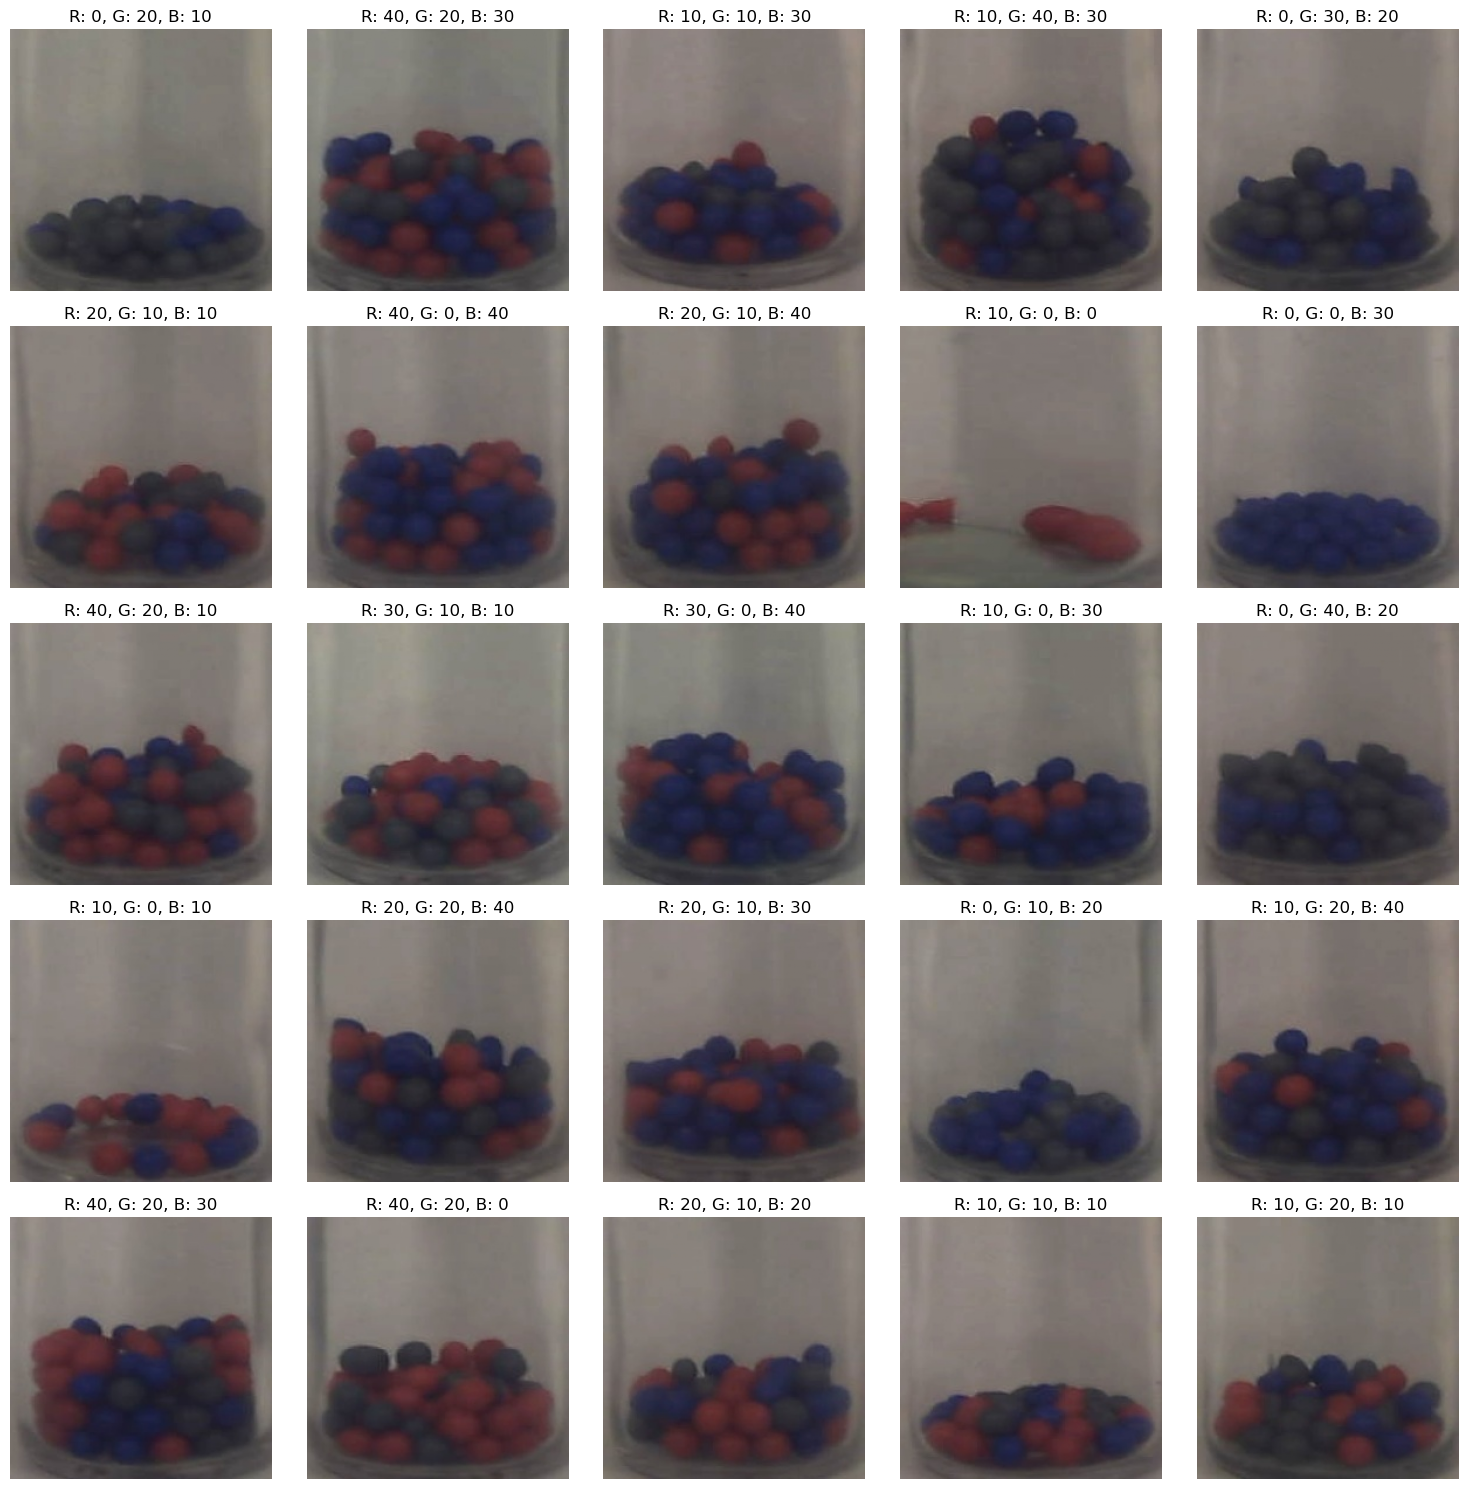

In [6]:
# Create a 5x5 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Plot the first 25 images and their labels
for idx, (image, label) in enumerate(zip(X_train[:25], y_train[:25])):
    axs[idx].imshow(image)
    axs[idx].set_title(f"R: {label[0]}, G: {label[1]}, B: {label[2]}")
    axs[idx].axis("off")  # Remove axes for clarity

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [40]:
# Load ResNet50 with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for regression
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.5), 
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='linear')
])(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Display model summary
# model.summary()

In [18]:
model = tf.keras.models.load_model("/Users/finnferchau/dev/EH_Bottle_Dataset/models/resnet50_model_v14.keras")

In [9]:
# Data augmentation

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.02,
    shear_range=0.0,
    zoom_range=0.0,
    horizontal_flip=False,
    vertical_flip=True,
    fill_mode='nearest'
)

# Augment the training data
datagen.fit(X_train)

In [42]:
# Training the model for 10 epochs

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 329ms/step - loss: 377.8009 - mae: 15.8682 - val_loss: 208.8881 - val_mae: 12.5852
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - loss: 256.9057 - mae: 13.5075 - val_loss: 205.8699 - val_mae: 12.4767
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - loss: 247.4175 - mae: 13.3377 - val_loss: 212.4848 - val_mae: 12.7051
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - loss: 238.3692 - mae: 13.1026 - val_loss: 211.6962 - val_mae: 12.6850
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - loss: 237.1993 - mae: 13.0910 - val_loss: 208.1311 - val_mae: 12.5661
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - loss: 234.7597 - mae: 13.0484 - val_loss: 203.7339 - val_mae: 12.3784
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - loss: 235.6223 - mae: 13.0506 - val_loss: 205.5854 - val_mae: 12.4708
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - loss: 233.9386 - mae: 13.1016 - val_loss: 201.5355 - val_mae: 12.1961


In [13]:
def plot_history(history):
    # Plot training & validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training & validation metrics (e.g., MAE)
    plt.figure(figsize=(12, 6))
    plt.plot(history['mae'], label='Training MAE')
    plt.plot(history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.show()

# plot_history(history.history)

In [52]:
# Save the model as a .keras file
model.save("resnet50_model_v12.keras")

In [17]:
log_dir = f"/Users/finnferchau/dev/EH_Bottle_Dataset/logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

# Training the model for 20 more epochs with all layers unfrozen

# # Unfreeze the base model
# for layer in base_model.layers:
#     layer.trainable = True

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='/Users/finnferchau/dev/EH_Bottle_Dataset/best_model.keras',       # Filepath to save the model
    monitor='val_loss',            # Metric to monitor (e.g., validation loss)
    save_best_only=True,           # Save only the best model
    save_weights_only=False,       # Save the entire model (weights + architecture)
    mode='min',                    # Save when 'val_loss' is minimized
    verbose=1                      # Print messages when saving
)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Train the model with the checkpoint callback
history_fine_tune = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[checkpoint_callback, tensorboard_callback]  # Add the callback here
)

Epoch 1/50


/opt/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 54.2109 - mae: 5.5995
Epoch 1: val_loss improved from inf to 23.29508, saving model to /Users/finnferchau/dev/EH_Bottle_Dataset/best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - loss: 54.1958 - mae: 5.5985 - val_loss: 23.2951 - val_mae: 3.7781
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - loss: 55.3335 - mae: 5.6423
Epoch 2: val_loss did not improve from 23.29508
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 974ms/step - loss: 55.3294 - mae: 5.6422 - val_loss: 29.0621 - val_mae: 4.1339
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - loss: 52.6676 - mae: 5.5185
Epoch 3: val_loss did not improve from 23.29508
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 52.6544 - mae: 5.5181 - val_loss: 49.6232 - val_mae: 5.1013
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 54.2698 - mae: 5.5914
Epoch 4: val_loss did not improve from 23.29508
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 54.2643 - mae: 5.5916 - val_loss: 30.0928 - val_ma

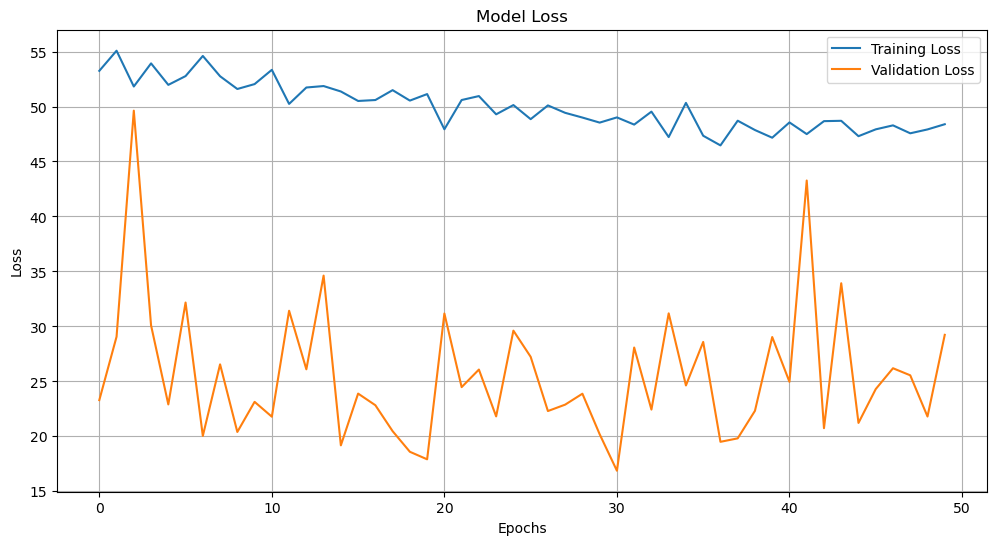

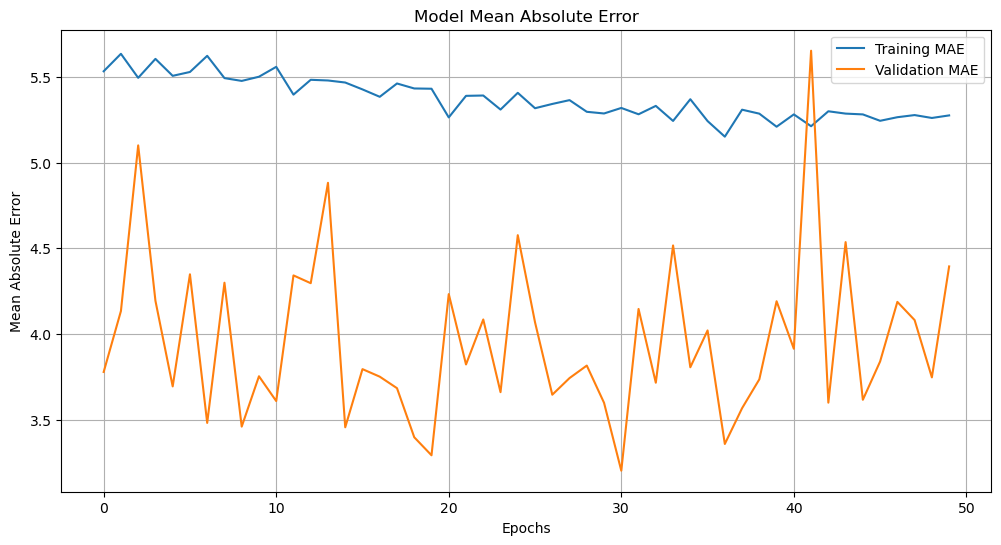

In [21]:
plot_history(history_fine_tune.history)

In [20]:
# Load the saved model
# model = tf.keras.models.load_model('resnet50_model_v5.keras')

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - loss: 17.1729 - mae: 3.2232
Test Loss: 16.87559700012207, Test MAE: 3.2013447284698486


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[12.504591 25.049734 18.318295]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[25.050056 33.044537 38.317562]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[17.761166 29.962902 12.928551]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[22.177017 16.26962  21.064976]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[ 1.8852544  2.8159175 28.870022 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[31.898247 37.276855 19.959583]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[29.325739 30.416948 20.097034]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[28.760769  33.42116    2.0958014]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[32.676495   2.0746627 20.687565 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[29.781708 19.959393 35.78185 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[17.179195 30.973322 37.187103]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[13.110626  26.922243   1.8861735]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[21.911915  22.66153    2.2887213]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[34.996174  

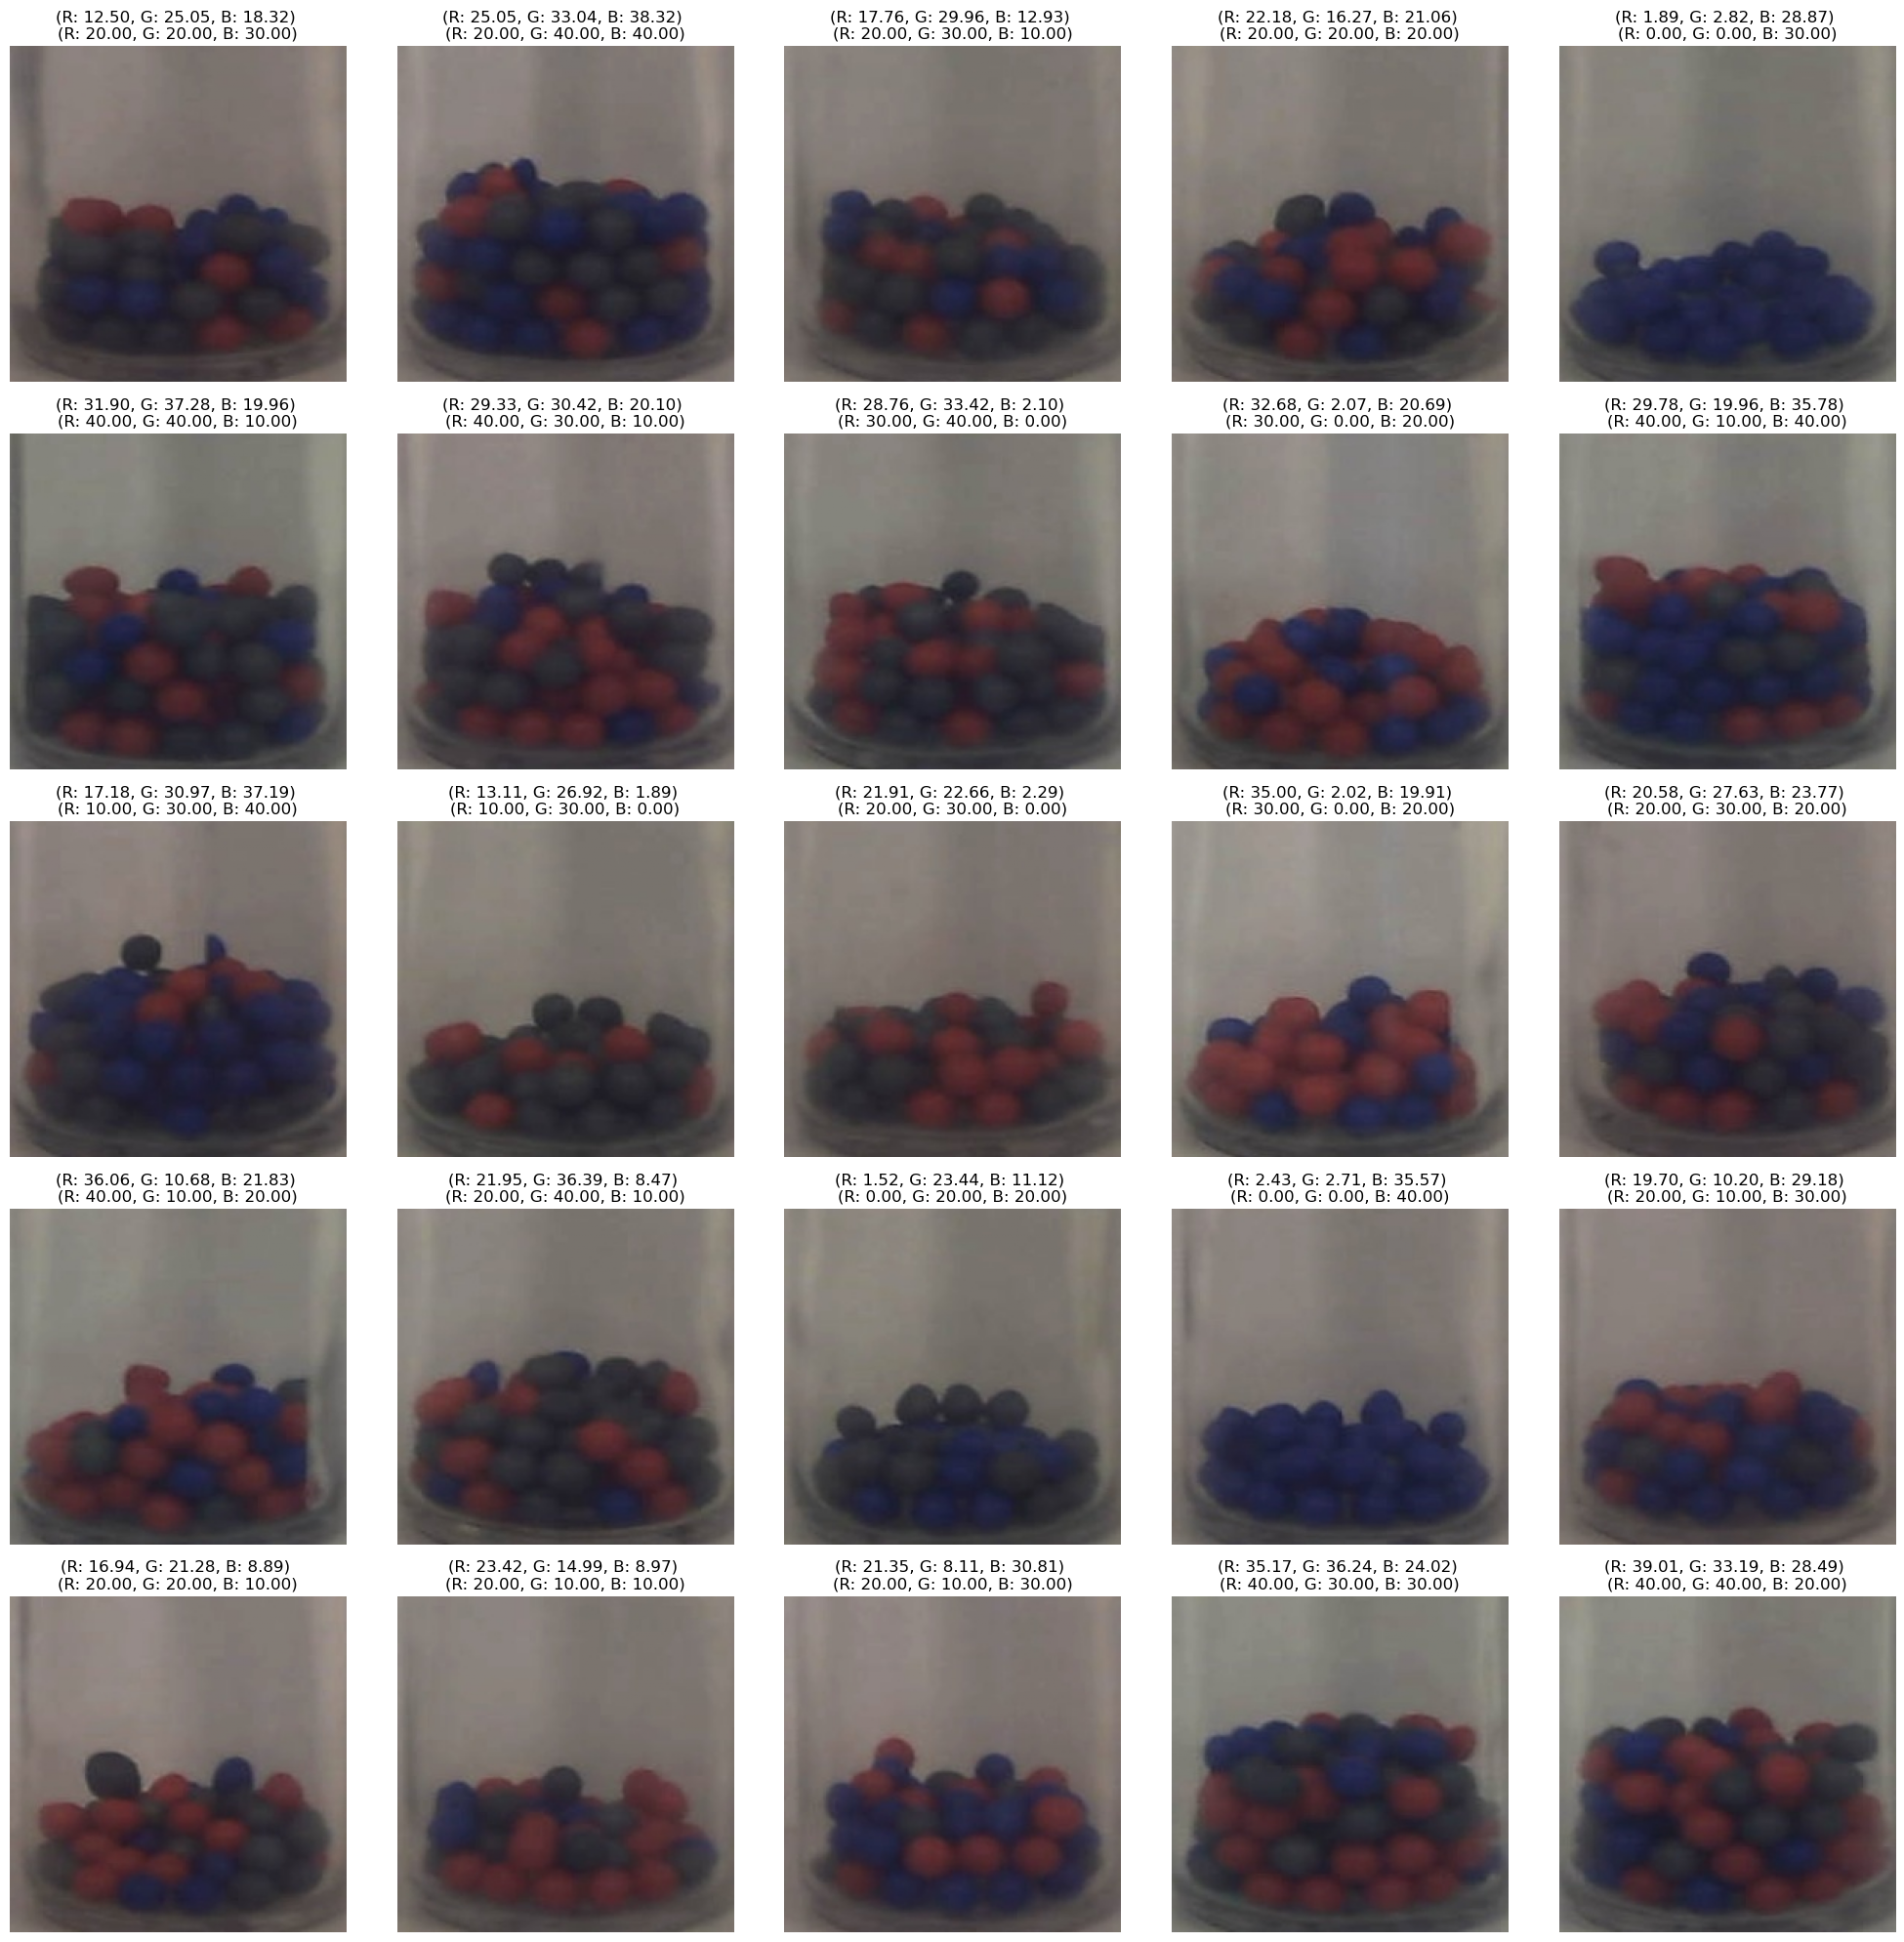

In [19]:
predictions = []

for img, label in zip(X_test[:25], y_test[:25]):
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    print(prediction)
    predictions.append((img, label, prediction[0]))

# Create a 5x5 grid of subplots
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Plot the first 25 images and their labels
for idx, (image,label, prediction) in enumerate(predictions):
    axs[idx].imshow(image[0])
    axs[idx].set_title(f"(R: {prediction[0]:.2f}, G: {prediction[1]:.2f}, B: {prediction[2]:.2f}) \n(R: {label[0]:.2f}, G: {label[1]:.2f}, B: {label[2]:.2f})")    
    axs[idx].axis("off")  # Remove axes for clarity

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd

model_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/models"
test_scores = []

for file_name in os.listdir(model_dir):
    if file_name.endswith(".keras"):
        model_path = os.path.join(model_dir, file_name)
        model = tf.keras.models.load_model(model_path)
        test_loss, test_mae = model.evaluate(X_test, y_test)
        test_scores.append((test_loss, test_mae, file_name))

df = pd.DataFrame(test_scores)
df

/opt/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 438 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - loss: 193.8790 - mae: 11.8240
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - loss: 195.3931 - mae: 11.9355
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - loss: 195.9850 - mae: 12.0018
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - loss: 199.9881 - mae: 12.1784
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - loss: 166.0547 - mae: 10.0764
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - loss: 144.7239 - mae: 9.2435
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - loss: 18.1770 - mae: 3.3403
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - loss: 17.1729 - mae: 3.2232
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - loss: 60.7577 - mae: 5.8523
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - loss: 303.8648 - mae: 14.1610
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - loss: 66.2579 - mae: 6.2327


0          1                         2
0   198.844208  12.044896   resnet50_model_v4.keras
1   200.035202  12.140274   resnet50_model_v6.keras
2   199.267563  12.165736   resnet50_model_v7.keras
3   204.006210  12.339516   resnet50_model_v5.keras
4   165.561172  10.017282   resnet50_model_v9.keras
5   145.711197   9.231652  resnet50_model_v11.keras
6    17.893435   3.307393  resnet50_model_v13.keras
7    16.875597   3.201345  resnet50_model_v14.keras
8    59.115791   5.815965  resnet50_model_v12.keras
9   299.300751  13.948209   resnet50_model_v8.keras
10   66.711723   6.224004  resnet50_model_v10.keras

In [30]:
df.columns = ["Mean Loss", "MAE", "Model Name"]
df.sort_values("MAE")

Mean Loss        MAE                Model Name
7    16.875597   3.201345  resnet50_model_v14.keras
6    17.893435   3.307393  resnet50_model_v13.keras
8    59.115791   5.815965  resnet50_model_v12.keras
10   66.711723   6.224004  resnet50_model_v10.keras
5   145.711197   9.231652  resnet50_model_v11.keras
4   165.561172  10.017282   resnet50_model_v9.keras
0   198.844208  12.044896   resnet50_model_v4.keras
1   200.035202  12.140274   resnet50_model_v6.keras
2   199.267563  12.165736   resnet50_model_v7.keras
3   204.006210  12.339516   resnet50_model_v5.keras
9   299.300751  13.948209   resnet50_model_v8.keras